# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***
### The Goal of this Project
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the [project repository](https://github.com/udacity/CarND-Advanced-Lane-Lines).

### The steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

### Step-1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

There are two main steps to this process: use chessboard images and OpenCV functions [findChessboardCorners()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) and [drawChessboardCorners()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners) to [extract image points and object points](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb), and then use the OpenCV functions [cv2.calibrateCamera()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html) and [cv2.undistort()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html) to compute the calibration and undistortion.

In [1]:
# extract object points and image points for camera calibration

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calib*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(1000)

cv2.destroyAllWindows()

### Step-2: Apply a distortion correction to raw images.

Text(0.5,1,'Undistorted Image')

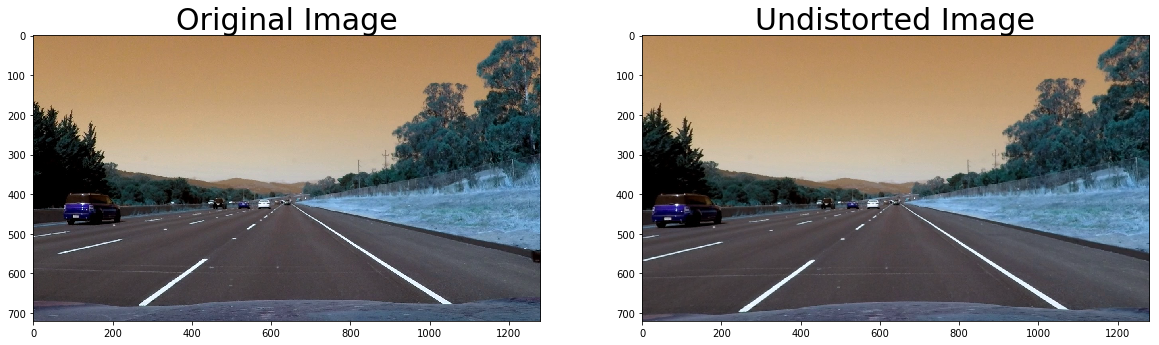

In [2]:
# Use objpoints and imgpoints to:
# (i) calibrate
# (ii) calculate distortion coefficients
# (iii) test undistortion on an image

import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])
#print(img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/straight_lines2_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Step-3: Use color transforms, gradients, etc., to create a thresholded binary image.

### Step-4: Apply a perspective transform to rectify binary image ("birds-eye view").

In [12]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
            # If we found corners, draw them! (just for fun)
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            # Choose offset from image corners to plot detected corners
            # This should be chosen to present the result at the proper aspect ratio
            # My choice of 100 pixels is not exact, but close enough for our purpose here
            offset = 100 # offset for dst points
            # Grab the image shape
            img_size = (gray.shape[1], gray.shape[0])

            # For source points I'm grabbing the outer four detected corners
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            # For destination points, I'm arbitrarily choosing some points to be
            # a nice fit for displaying our warped result 
            # again, not exact, but close enough for our purposes
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                         [img_size[0]-offset, img_size[1]-offset], 
                                         [offset, img_size[1]-offset]])
            # Given src and dst points, calculate the perspective transform matrix
            M = cv2.getPerspectiveTransform(src, dst)
            # Warp the image using OpenCV warpPerspective()
            warped = cv2.warpPerspective(undist, M, img_size)

            # Return the resulting image and matrix
            return warped

In [16]:
# Get perspective transform
img = cv2.imread('test_images/test1.jpg')
nx = 9
ny = 6
warped_im = corners_unwarp(img, nx, ny, mtx, dist)

TypeError: Image data cannot be converted to float

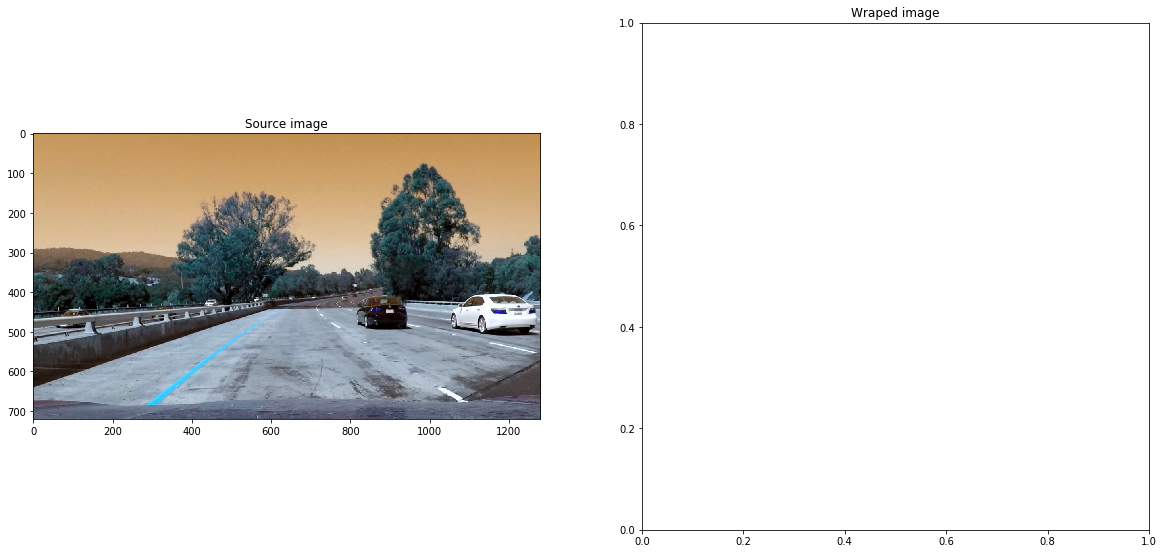

In [17]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Wraped image')
ax2.imshow(warped_im)

### Step-5: Detect lane pixels and fit to find the lane boundary.

### Step-6: Determine the curvature of the lane and vehicle position with respect to center.

### Step-7: Warp the detected lane boundaries back onto the original image.

### Step-8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

**Similar to Project-1, the tools I have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection, etc. My goal is to piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once I have a working pipeline, I will try it out on the video stream.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# calculating average (can also use np.mean() instead)
def ap(ip):
    sp = 0
    for p in ip:
        sp += p
    avg_p = sp/len(ip)
    return avg_p

# calculating average for both the co-ordinates of a line 
def avg_cd(ax1, ay1, ax2, ay2):
    return int(ap(ax1)), int(ap(ay1)), int(ap(ax2)), int(ap(ay2)) 

# calculating slope of a line
def slope(x1, y1, x2, y2):
    return ((y2-y1)/(x2-x1))

# calculating y-intercept of a line
def intercept(x,y,m):
    return y - m*x

# improved draw_line() function (average and extrapolation)
def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    ax1_r = []
    ay1_r = []
    ax2_r = []
    ay2_r = []
    
    ax1_l = []
    ay1_l = []
    ax2_l = []
    ay2_l = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            m = slope(x1,y1,x2,y2)
            #on inverted image axis - right lane line has positive slope
            if m > 0.3 :
                ax1_r.append(x1)
                ay1_r.append(y1)
                ax2_r.append(x2)
                ay2_r.append(y2)
            #on inverted image axis - left lane line has negative slope
            elif m < -0.3:
                ax1_l.append(x1)
                ay1_l.append(y1)
                ax2_l.append(x2)
                ay2_l.append(y2)

    #calculating average co-ordinates 
    x1_avg_r, y1_avg_r, x2_avg_r, y2_avg_r = avg_cd(ax1_r, ay1_r, ax2_r, ay2_r)
    x1_avg_l, y1_avg_l, x2_avg_l, y2_avg_l = avg_cd(ax1_l, ay1_l, ax2_l, ay2_l)
 
    #calculating average slope
    right_m = slope(x1_avg_r, y1_avg_r,x2_avg_r, y2_avg_r)
    left_m = slope(x1_avg_l, y1_avg_l, x2_avg_l, y2_avg_l)

    #calculating average intercept
    right_c  = intercept(x1_avg_r, y1_avg_r, right_m)
    left_c = intercept(x1_avg_l, y1_avg_l, left_m)
  
    imshape = img.shape

    #drawing extrapolated right lane line (positive slope - inverted axis)
    right_top_x = 500 # region of interest
    right_top_y = int(right_m*right_top_x + right_c)
    
    right_bottom_y = imshape[1]
    right_bottom_x = int((right_bottom_y-right_c)/right_m)
    
    cv2.line(img, (right_top_x, right_top_y), (right_bottom_x, right_bottom_y), color, thickness)
    
    #drawing extrapolated left lane line (negative slope - inverted axis)
    left_top_y = 320 # region of interest
    left_top_x = int((left_top_y-left_c)/left_m)
    
    left_bottom_x = 0
    left_bottom_y = int(left_m*left_bottom_x + left_c)
        
    cv2.line(img, (left_top_x, left_top_y), (left_bottom_x, left_bottom_y), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


def img_processing(image):
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size=5)
    edges = canny(blur_gray, low_threshold=60, high_threshold=190)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments

    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    # Draw the lines on the edge image
    return weighted_img(lines, image)
    
if not os.path.exists('test_images_output'):
    os.mkdir('test_images_output')
    
#reading, processing, saving, and displaying all images
for img in os.listdir("test_images/"):
    image = mpimg.imread('test_images/'+img)
    mpimg.imsave('test_images_output/'+img, img_processing(image), format="png")
    image_out = mpimg.imread('test_images_output/'+img)
    plt.figure()
    plt.imshow(image_out)
    




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size=5)
    edges = canny(blur_gray, low_threshold=60, high_threshold=190)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 140    # maximum gap in pixels between connectable line segments

    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    # Draw the lines on the edge image
    result = weighted_img(lines, image)
    return result

if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))